In [19]:
def boyer_moore_vote(predictions):
    candidate = None
    count = 0

    for prediction in predictions:
        if count == 0:
            candidate = prediction
            count = 1
        elif prediction == candidate:
            count += 1
        else:
            count -= 1
    
    return candidate

In [20]:
import numpy as np
from collections import Counter

# Calculate Gini Impurity
def gini_impurity(y):
    classes = Counter(y)
    total = len(y)
    return 1.0 - sum((count / total) ** 2 for count in classes.values())

# Calculate Entropy
def entropy(y):
    classes = Counter(y)
    total = len(y)
    return -sum((count / total) * np.log2(count / total) for count in classes.values() if count != 0)


In [21]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion='gini'):
        self.max_depth = max_depth
        self.criterion = gini_impurity if criterion == 'gini' else entropy
        self.tree = None

    def fit(self, X, y, depth=0):
        # Stop if max depth is reached or no more splits are possible
        if depth == self.max_depth or len(set(y)) == 1:
            # Use Boyer-Moore to select the majority class at the leaf node
            return boyer_moore_vote(y)

        # Find the best split
        best_split = self._find_best_split(X, y)
        if not best_split:
            # Use Boyer-Moore to select the majority class when no further split is possible
            return boyer_moore_vote(y)

        # Recursively build the tree
        left_indices, right_indices = best_split['groups']
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {'feature_index': best_split['feature_index'], 'threshold': best_split['threshold'],
                'left': left_subtree, 'right': right_subtree}

    def _find_best_split(self, X, y):
        best_split = {}
        best_criteria = float('inf')
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices, right_indices = self._split(X, y, feature_index, threshold)
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                # Calculate the impurity of this split
                impurity = self._calculate_impurity(y[left_indices], y[right_indices])
                if impurity < best_criteria:
                    best_criteria = impurity
                    best_split = {'feature_index': feature_index, 'threshold': threshold,
                                  'groups': (left_indices, right_indices)}
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_indices = np.where(X[:, feature_index] <= threshold)[0]
        right_indices = np.where(X[:, feature_index] > threshold)[0]
        return left_indices, right_indices

    def _calculate_impurity(self, left_group, right_group):
        total_size = len(left_group) + len(right_group)
        left_impurity = (len(left_group) / total_size) * self.criterion(left_group)
        right_impurity = (len(right_group) / total_size) * self.criterion(right_group)
        return left_impurity + right_impurity

    def predict(self, X):
        return np.array([self._predict_single(row, self.tree) for row in X])

    def _predict_single(self, row, tree):
        if isinstance(tree, dict):
            if row[tree['feature_index']] <= tree['threshold']:
                return self._predict_single(row, tree['left'])
            else:
                return self._predict_single(row, tree['right'])
        else:
            return tree


In [22]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, criterion='gini', max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.criterion = criterion
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
            bootstrap_X = X[bootstrap_indices]
            bootstrap_y = y[bootstrap_indices]
            tree = DecisionTree(max_depth=self.max_depth, criterion=self.criterion)
            tree.tree = tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from all trees
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Apply Boyer-Moore Voting Algorithm for each sample
        final_predictions = []
        for i in range(X.shape[0]):
            sample_predictions = predictions[:, i]
            majority_vote = boyer_moore_vote(sample_predictions)
            final_predictions.append(majority_vote)
        return np.array(final_predictions)


class ExtraTrees:
    def __init__(self, n_estimators=10, max_depth=None, criterion='gini', max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.criterion = criterion
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # No bootstrap sampling, just random feature selection
            tree = DecisionTree(max_depth=self.max_depth, criterion=self.criterion)
            tree.tree = tree.fit(X, y)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from all trees
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Apply Boyer-Moore Voting Algorithm for each sample
        final_predictions = []
        for i in range(X.shape[0]):
            sample_predictions = predictions[:, i]
            majority_vote = boyer_moore_vote(sample_predictions)
            final_predictions.append(majority_vote)
        return np.array(final_predictions)


In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

# K-Fold cross-validation
def cross_validate(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    accuracies, f1_scores = [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    return np.mean(accuracies), np.mean(f1_scores)


In [24]:
from sklearn.datasets import load_wine

# Load dataset
wine_data = load_wine()
X, y = wine_data.data, wine_data.target


print(X.shape)
print(y.shape)
print(y)
print(np.unique(y))

(178, 13)
(178,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 1 2]


In [28]:
count_1 = 0
count_2 = 0 
count_3 = 0
 
for i in range(len(y)):
    if y[i] == 0:
        count_1 +=1
    elif y[i] == 1:
        count_2+=1
        
    else :
        count_3+=1
        
print(count_1,count_2,count_3)             
      

59 71 48


In [26]:
from sklearn.datasets import load_wine

# Load dataset
wine_data = load_wine()
X, y = wine_data.data, wine_data.target

# Random Forest and Extra Trees with different parameters
rf_model = RandomForest(n_estimators=10, max_depth=7, criterion='gini')
et_model = ExtraTrees(n_estimators=10, max_depth=7, criterion='gini')

# Perform cross-validation
rf_accuracy, rf_f1 = cross_validate(rf_model, X, y)
et_accuracy, et_f1 = cross_validate(et_model, X, y)

print(f'Random Forest - Accuracy: {rf_accuracy:.4f}, F1-Score: {rf_f1:.4f}')
print(f'Extra Trees - Accuracy: {et_accuracy:.4f}, F1-Score: {et_f1:.4f}')


Random Forest - Accuracy: 0.9325, F1-Score: 0.9323
Extra Trees - Accuracy: 0.9216, F1-Score: 0.9226


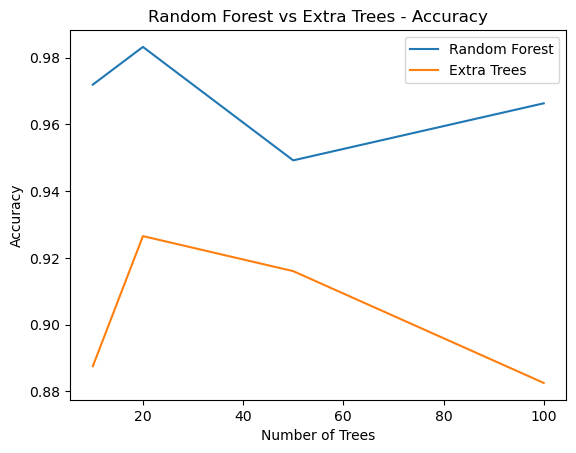

In [27]:
import matplotlib.pyplot as plt

# Sample hyperparameter results (for demonstration)
n_trees = [10, 20, 50, 100]
rf_accuracies = [0.9719, 0.9832, 0.9492, 0.9663]
et_accuracies = [0.8875, 0.9265, 0.9160, 0.8825]

# Plot Accuracy
plt.plot(n_trees, rf_accuracies, label='Random Forest')
plt.plot(n_trees, et_accuracies, label='Extra Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest vs Extra Trees - Accuracy')
plt.legend()
plt.show()
